# install library

In [ ]:
# google colab üzerinde çalıştığım için verileri her seferinde verileri colab'a yüklememek için drive'ıma yükledim. 
# Burada drive google colab'a bağlanır.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### We may need to restart the runtime for the library we have updated library to generate graphs.

In [ ]:
#bertopic kullanmak için
!pip install bertopic
!pip install transformers==4.11.3
!pip install tokenizers==0.10.3
!pip install sentencepiece==0.1.96
from bertopic import BERTopic
from transformers import AutoModel, AutoTokenizer # bert için içeri aktardığımız önceden eğitilmiş embedding modeli kendi modelimizde kullanabilmek için bazı işlemlerden geçirtmek için bu kütüphaneden yararlanılır.
import pandas as pd # veriyi excelden almak ve veriyle önişlemler gerçekleşitrmek için kütüphane
!pip install wordcloud==1.8.1
from wordcloud import WordCloud # veride geçen en çok kelimeleri görselleştirmek için kelime bulutu kütüphanesi
import matplotlib.pyplot as plt # grafik oluşturmak için kütüphane
!pip install gensim==4.1.2 # konu modellemek için gensim'in bazı modüllerinden yararlanılır. 
import gensim.corpora as corpora # veriyi lda modelinde kullanmak için sözlük modülü
from gensim.models.coherencemodel import CoherenceModel # modeli değerlendirmek için modül
import nltk # türkçe stopwords'leri kullanmak için
import re # yazıları daha anlaşılır yapmak için veri değiştirme kütüphanesi
from nltk.tokenize import RegexpTokenizer # Cümleleri makine için daha anlaşılır yapmak için bölmek için modül
from collections import Counter # veride geçen kelimeleri saydırmak için kütüphane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.9 MB/s 
     |████████████████████████████████| 88 kB 7.4 MB/s 
     |████████████████████████████████| 5.2 MB 47.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 85 kB 5.0 MB/s 
     |████████████████████████████████| 4.4 MB 51.8 MB/s 
     |████████████████████████████████| 1.2 MB 53.2 MB/s 
     |████████████████████████████████| 101 kB 8.6 MB/s 
     |████████████████████████████████| 636 kB 51.1 MB/s 
     |████████████████████████████████| 6.6 MB 3.1 MB/s 
     |████████████████████████████████| 1.1 MB 49.3 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2342138 sha256=bdae1bee61e8fa6d6f3ae8a993566097ab7a68bec6bd8222ad43fde7db65b415
  Stored in directory: /root/.cache/p

# data

In [ ]:
# veriler farklı excel'ler üzerinde olduğu için pandas üzerinden okunur ve birleştirilir.

df1 = pd.read_excel('/content/drive/MyDrive/CallToTexNewData.xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/CallToTexNewData1.xlsx')
df3 = pd.read_excel('/content/drive/MyDrive/CallToTexNewData2.xlsx')
df4 = pd.read_excel('/content/drive/MyDrive/CallToTexNewData3.xlsx')
df = df1.append([df2,df3,df4], ignore_index=True)

# sadece müşteri çağrıları ve ürünlerle çalışağımızdan aşağıdaki veriler verisetinden çıkarılır.
df.drop(columns=['CallId','Kuyruk','AgentText'], inplace=True)

df


,CustomerText,Kuyruk Konusu
0,*d *d alo,Uzaktan Erişim
1,*d *d *d iyi günler nereden arıyorsunuz evet b...,Memnuniyet Araması
2,iyi günler ben bu kampanyaya *****ılırım başar...,Öncelikli Müşteri Televizyon
3,*d *d alo günaydın merhaba buyurun benim benim...,Uzaktan Erişim
4,iyi günler günaydın şey ben bugün gün kaldım d...,Öncelikli Müşteri Beyaz Eşya
...,...,...
19995,eee merhaba iyi günler dilerim elimde * tablet...,Öncelikli Müşteri Telefon
19996,kolay gelsin opera * ***** vardı da ***** tele...,Televizyon
19997,*d *d yani alo buyurun dinliyorum evet aldım ü...,Memnuniyet Araması
19998,açayım isim neydi barış bey merhaba bizim * ta...,Satış


In [ ]:
df['Kuyruk Konusu'].nunique() # kaç tane konu var?

17

In [ ]:
df['Kuyruk Konusu'].value_counts()

Telefon                         4091
Beyaz Eşya                      2937
Televizyon                      2379
Çözüm Ekibi                     2315
Uzaktan Erişim                  1885
Memnuniyet Araması              1883
Öncelikli Müşteri Telefon       1515
Öncelikli Müşteri Beyaz Eşya    1075
Öncelikli Müşteri Televizyon     851
Satış                            503
Kurulum                          478
İngilizce Çağrılar                62
Kurumsal Satış - Telefon          12
Önceliklik Müşteri Telefon         7
Kurumsal Satış                     5
Hizmet Takibi Servis Takibi        1
Yeni Ürün Tanıtımı                 1
Name: Kuyruk Konusu, dtype: int64

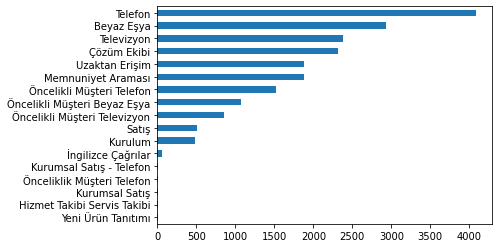

In [ ]:
df['Kuyruk Konusu'].value_counts().sort_values().plot(kind = 'barh')

In [ ]:
# algoritmanın bazı konulardaki farklılıkları anlayamadığı düşünülerek konular birleştirilmiştir.
# öncelikli müşteri telefon ile telefon arasındaki farkı anlamayacağı düşünülerek birleştirilmiştir.

df['Kuyruk Konusu'] = df['Kuyruk Konusu'].str.replace('Öncelikli Müşteri Telefon', 'Telefon')
df['Kuyruk Konusu'] = df['Kuyruk Konusu'].str.replace('Öncelikli Müşteri Beyaz Eşya', 'Beyaz Eşya')
df['Kuyruk Konusu'] = df['Kuyruk Konusu'].str.replace('Öncelikli Müşteri Televizyon', 'Televizyon')
df['Kuyruk Konusu'] = df['Kuyruk Konusu'].str.replace('Kurumsal Satış - Telefon', 'Telefon')
df['Kuyruk Konusu'] = df['Kuyruk Konusu'].str.replace('Önceliklik Müşteri Telefon', 'Telefon')
df['Kuyruk Konusu'] = df['Kuyruk Konusu'].str.replace('Kurumsal Satış', 'Satış')

df['Kuyruk Konusu'].value_counts()

Telefon                        5625
Beyaz Eşya                     4012
Televizyon                     3230
Çözüm Ekibi                    2315
Uzaktan Erişim                 1885
Memnuniyet Araması             1883
Satış                           508
Kurulum                         478
İngilizce Çağrılar               62
Hizmet Takibi Servis Takibi       1
Yeni Ürün Tanıtımı                1
Name: Kuyruk Konusu, dtype: int64

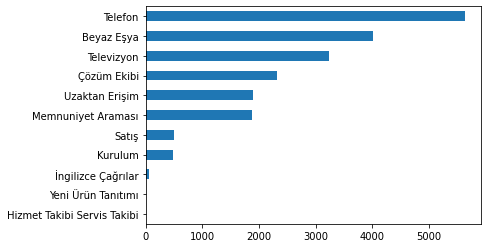

In [ ]:
df['Kuyruk Konusu'].value_counts().sort_values().plot(kind = 'barh')

In [ ]:
# 3 konunun çok az verisi olduğundan dolayı modelde kullanılmaz, çıkarılır.

df.drop(df[df['Kuyruk Konusu'] == 'Yeni Ürün Tanıtımı'].index, inplace = True)
df.drop(df[df['Kuyruk Konusu'] == 'Hizmet Takibi Servis Takibi'].index, inplace = True)
df.drop(df[df['Kuyruk Konusu'] == 'İngilizce Çağrılar'].index, inplace = True)
df

,CustomerText,Kuyruk Konusu
0,*d *d alo,Uzaktan Erişim
1,*d *d *d iyi günler nereden arıyorsunuz evet b...,Memnuniyet Araması
2,iyi günler ben bu kampanyaya *****ılırım başar...,Televizyon
3,*d *d alo günaydın merhaba buyurun benim benim...,Uzaktan Erişim
4,iyi günler günaydın şey ben bugün gün kaldım d...,Beyaz Eşya
...,...,...
19995,eee merhaba iyi günler dilerim elimde * tablet...,Telefon
19996,kolay gelsin opera * ***** vardı da ***** tele...,Televizyon
19997,*d *d yani alo buyurun dinliyorum evet aldım ü...,Memnuniyet Araması
19998,açayım isim neydi barış bey merhaba bizim * ta...,Satış


In [ ]:
df['Kuyruk Konusu'].value_counts()

Telefon               5625
Beyaz Eşya            4012
Televizyon            3230
Çözüm Ekibi           2315
Uzaktan Erişim        1885
Memnuniyet Araması    1883
Satış                  508
Kurulum                478
Name: Kuyruk Konusu, dtype: int64

In [ ]:
# 3 konunun çok az verisi olduğundan dolayı modelde kullanılmaz, çıkarılır.
df.drop(df[df['Kuyruk Konusu'] == 'Kurulum'].index, inplace = True)
df.drop(df[df['Kuyruk Konusu'] == 'Memnuniyet Araması'].index, inplace = True)
df.drop(df[df['Kuyruk Konusu'] == 'Satış'].index, inplace = True)

df

,CustomerText,Kuyruk Konusu
0,*d *d alo,Uzaktan Erişim
2,iyi günler ben bu kampanyaya *****ılırım başar...,Televizyon
3,*d *d alo günaydın merhaba buyurun benim benim...,Uzaktan Erişim
4,iyi günler günaydın şey ben bugün gün kaldım d...,Beyaz Eşya
5,iyi günler efendim ııı cuma günü de yok herhal...,Beyaz Eşya
...,...,...
19993,*d *d *d *d teşekkürler alo alo şimdi şimdi ha...,Uzaktan Erişim
19994,şimdi mesela geldi iyi günler efendim iyi çalı...,Telefon
19995,eee merhaba iyi günler dilerim elimde * tablet...,Telefon
19996,kolay gelsin opera * ***** vardı da ***** tele...,Televizyon


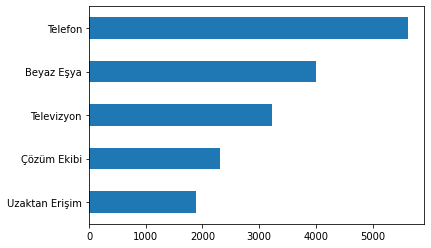

In [ ]:
df['Kuyruk Konusu'].value_counts().sort_values().plot(kind = 'barh')

In [ ]:
df['Kuyruk Konusu'].value_counts() # konular ve sayıları

Telefon           5625
Beyaz Eşya        4012
Televizyon        3230
Çözüm Ekibi       2315
Uzaktan Erişim    1885
Name: Kuyruk Konusu, dtype: int64

# preprocess data

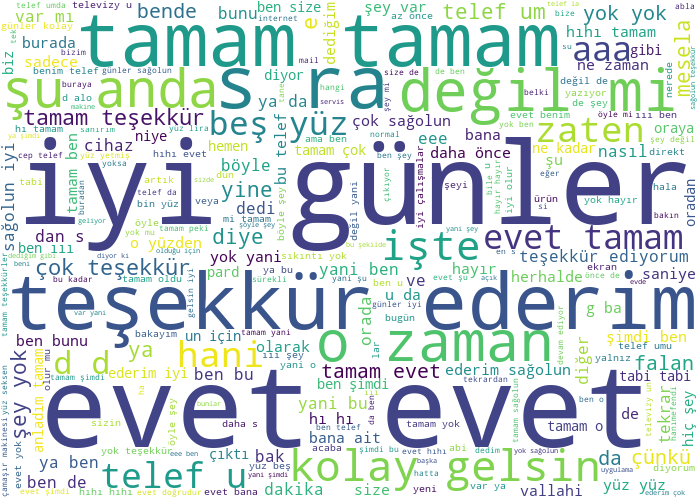

In [ ]:
# verilerde geçen en çok 250 kelime (kelime bulutu)
long_string = ','.join(list(df['CustomerText'].values))
wordcloud = WordCloud(background_color="white", max_words=250, width=700, height=500, contour_width=10, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
# doğal dil işlemede normalde ek çıkarmak için stemmer ve lemmmatizer kullanılır fakat bizim verimizde bunlar uygulandığında bazı kelimeler kesilip anlamsızlaşmıştır. 
# bu yüzden verilerin manuel olarak ekleri silinmiştir ve bazı kelimeler düzeltilmiştir. örnek: m*taj > montaj
df['CustomerText'] = df['CustomerText'].str.replace(r'birim[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'birim', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'tablet[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'tablet', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'telefon[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'telefon', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'televizyon[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'televizyon', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'makine[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'makine', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'şifre[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'şifre', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'ekran[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'ekran', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'garanti[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'garanti', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'ar\u0131za[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'arıza', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r's\u00fcp\u00fcrge[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'süpürge', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'siz[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'siz', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'do\u011fru[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'doğru', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'gel[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'gel', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'gir[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'gir', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'tamam[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'tamam', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'biz[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'biz', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'ben[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'ben', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'ses[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'ses', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'ayar[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'ayar', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'uygulama[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'uygulama', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'numara[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'numara', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'bey[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'bey', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'bilgisayar[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'bilgisayar', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'buzdola[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'buzdolap', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'ankast[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'ankastre', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'davlumbaz[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'davlumbaz', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'f\u0131r\u0131n[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'fırın', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'mikrodalga[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'mikro dalga', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'mikrodalga', 'mikro dalga', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'mikro dalga[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'mikro dalga', regex=True)

df['CustomerText'] = df['CustomerText'].str.replace(r'set \u00fcst\u00fc[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'set üstü', regex=True)

df['CustomerText'] = df['CustomerText'].str.replace(r'bozu[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'arıza', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'buz dola[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'buzdolap', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'buluray[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'bluray', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'eniks[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'nx', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'enx[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'nx', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'enix[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'nx', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'klima[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'klima', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'diz\u00fcst\u00fc[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'bilgisayar', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'diz \u00fcst\u00fc[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'bilgisayar', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'laptop[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'bilgisayar', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'notebook[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'bilgisayar', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'faks[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'faks', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'yaz\u0131c\u0131[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'yazıcı', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'taray\u0131c\u0131[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'tarayıcı', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\u00e7amas\u0131r[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'çamaşır', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'kurutma[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'kurutma', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'makina[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'makine', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'telekom[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'telekom', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\u015fikayet[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'şikayet', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'cihaz[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'cihaz', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\bara[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'arama', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'internet[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'internet', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'mesaj[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'mesaj', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\btel\b', 'telefon', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\btelef\b', 'telefon', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'mobil[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'mobil', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\btel\b', 'telefon', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'bula\u015f\u0131k[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'bulaşık', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'sistem[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'sistem', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\bpc\b', 'bilgisayar', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'ses sistem', 'ev sinema sistem', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'sinema sistem', 'ev sinema sistem', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\bkayd', 'kayıt', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\btv\'[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'tv', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\btv\b', 'televizyon', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\btelevizy\b', 'televizyon', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\btrol\b', 'kontrol', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'batarya[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'batarya', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'm\*taj', 'montaj', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'montaj[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'montaj', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'm\*it\u00f6r', 'monitör', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'monit\u00f6r[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'monitör', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\u015farj[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'şarj', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'servis[a-z+\u0131+\u011f+\u011e+\u0131+\u0130+\u00f6+\u00d6+\u00fc+\u00dc+\u015f+\u015e+\u00e7+\u00c7]+', 'servis', regex=True)
df['CustomerText'] = df['CustomerText'].str.replace(r'\bkod', 'kod', regex=True)


df

,CustomerText,Kuyruk Konusu
0,*d *d alo,Uzaktan Erişim
2,iyi günler ben bu kampanyaya *****ılırım başar...,Televizyon
3,*d *d alo günaydın merhaba buyurun ben ben buy...,Uzaktan Erişim
4,iyi günler günaydın şey ben bugün gün kaldım d...,Beyaz Eşya
5,iyi günler efendim ııı cuma günü de yok herhal...,Beyaz Eşya
...,...,...
19993,*d *d *d *d teşekkürler alo alo şimdi şimdi ha...,Uzaktan Erişim
19994,şimdi mesela gel iyi günler efendim iyi çalışm...,Telefon
19995,eee merhaba iyi günler dilerim elimde * tablet...,Telefon
19996,kolay gel opera * ***** vardı da ***** televiz...,Televizyon


In [ ]:
# doğal dil işleme için ön işleme

tokenizer = RegexpTokenizer(r'\w+') # Cümleleri küçük ifadelere böler değişkeni tanımlanır.
punct_re=lambda x :" ".join(tokenizer.tokenize(x.lower())) # Verileri küçük harflere dönüştür değişkeni tanımlanır.

nltk.download('stopwords') # nltk'den stopwords indirilir. Veri ne kadar sade olsa o kadar iyidir bundan dolayı cümleye anlam katmayan gereksiz kelimelerden(stopword) kurtulmak istenir.
stop_word_list = nltk.corpus.stopwords.words('turkish')  # Türkçe stopword'leri bir değişkene atanır

# stopword'leri çıkarmak için fonksiyon
def stopword_extraction(values):
    wordFilter = [word for word in values.split() if word not in stop_word_list]
    notStopword = " ".join(wordFilter)
    return notStopword

df["CustomerText"] = df["CustomerText"].apply(punct_re) # metin verileri küçük harflere çevir
df['CustomerText'] = df['CustomerText'].apply(lambda x: stopword_extraction(x)) # metin verilerinden stopword'leri çıkar

df['CustomerText'] = df['CustomerText'].str.replace(r'\S*@\S*\s?', '', regex=True) # e-posta sil
df['CustomerText'] = df['CustomerText'].str.replace(r'[^\w\s]', '', regex=True) # noktalama işaretlerini sil
df['CustomerText'] = df['CustomerText'].str.replace(r'http\S+', '', regex=True) # bağlantı sil
df['CustomerText'] = df['CustomerText'].str.replace(r'www\S+', '', regex=True) # bağlantı sil

df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,CustomerText,Kuyruk Konusu
0,d d alo,Uzaktan Erişim
2,iyi günler ben kampanyaya ılırım başarıyla s u...,Televizyon
3,d d alo günaydın merhaba buyurun ben ben buyur...,Uzaktan Erişim
4,iyi günler günaydın ben bugün gün kaldım zaman...,Beyaz Eşya
5,iyi günler efendim ııı cuma günü yok herhalde ...,Beyaz Eşya
...,...,...
19993,d d d d teşekkürler alo alo şimdi şimdi hayır ...,Uzaktan Erişim
19994,şimdi mesela gel iyi günler efendim iyi çalışm...,Telefon
19995,eee merhaba iyi günler dilerim elimde tablet v...,Telefon
19996,kolay gel opera vardı televizyon silindi bugün...,Televizyon


In [ ]:
# modelin anlamsız sonuçlar doğurmasını engellemek için herhangi bir kelimeye bağlı olmayan kısa harf/hece/kelime çıkarılır.
remove_words =['ha','haa', 'ben', 'mi','yok', 'var', 'an', 'hı', 'alo','dan','ç','f','d', 'gün', 'onu','ben','mı' 'mi','anda','size','oldu','olur','r',
               'he', 'la', 'den','olab','bak','hah','ba','hım','gir','gel','siz','biz','ilg','tl','baska','evet', 'ııı','eee','tamam','simdi', 'falan', 'zaten', 'mesela', 'aaa', 'herhalde','tabi', 'yine',
                'kolay', 'gelsin', 'teşekkür', 'ederim', 'dakika', 'bir', 'saniye', 'günler', 'iyi', 'akşamlar',
                'vallahi', 'hani', 'işte', 'efendim', 'canım', 'peki', 'abi', 'hıhı', 'sağolun','hehe', 'buyurun','hanım',
                'benim','zaman', 'bey', 'söyle', 'diyor', 'değil', 'bana', 'sizi', 'sonra', 'bunu','anladım','hayır',
                'teşekkürler', 'böyle', 'öyle','bilmiyorum', 'burada','bunun','dediğim', 'aynen','tekrar','günaydın',
                'önce', 'şeyi','dedi','bende', 'sadece','diğer','orada','sağolasın','rica','ulaştı','valla', 'bugün',
                'bağlayab','misiniz', 'hanımefendi', 'abicim', 'kızım', 'hocam', 'abla', 'ablacığım', 'inşallah', 'hayırlı','hayırlı işler',
                'beyefendi', 'şekilde', 'kardeşim', 'dediler', 'ismim', 'hemen', 'diyorum','bakın','bes yüz','e','merhaba','pard','un','bin yüz',
                'pardon','doğru', 'merhabalar','gerçekten', 'şey', 'çünkü','s','ra','nasıl', 'u','hoşçakalın','müsait','çok', 'um','umu',
               'trol edelim','miyim','murat','ahmet','şöyle','olabilir','eğer','fatih','hakan','ayse','elif','gökhan','deniz',
               'can', 'bes','öz_gi','tan','yüz','bin','yetmiş','seksen','doksan','atmış','tane','uda','nasılsınız','için','heh','aa','si','sanırım','artık',
               'sağol','ay','olarak', 'almıştım','aldık','aldım','hee','no','on','sen','hiç','şeyler','bunlar','söyleyeyim','dedim',
               'şimdi','arama','musunuz','başka','beş','model','kod','ait','dün','yarın','numara','değ','allah','umun','tire','cihaz']

sil = r'\b(?:{})\b'.format('|'.join(remove_words)) # kelimeleri silmek için sil değişkeni
df['CustomerText'] = df['CustomerText'].str.replace(sil, '', regex=True) # kelimeler silinir.
df.drop(df[df['CustomerText'].map(len) < 10].index, inplace=True) # metin verilerinde 10'dan az karaktere sahipleri sil

# index düzelt
df.reset_index(inplace=True)
df.set_index('index')
df.drop(columns=['index'], inplace=True)

df

,CustomerText,Kuyruk Konusu
0,kampanyaya ılırım başarıyla uçlandırmak te...,Televizyon
1,h l gece uğraştım hallettim ilginize ...,Uzaktan Erişim
2,kaldım saat derecede evde sırf...,Beyaz Eşya
3,cuma günü üstte gürbüz lira abimiz arıza...,Beyaz Eşya
4,müsaitim smarta pencerede gör...,Uzaktan Erişim
...,...,...
16953,dinliyorum vardı yüzden ...,Uzaktan Erişim
16954,çalışmalar diliyorum zamandı time işl...,Telefon
16955,dilerim elimde tablet galaxy tab mart mar...,Telefon
16956,opera vardı televizyon silindi çalışıyordu...,Televizyon


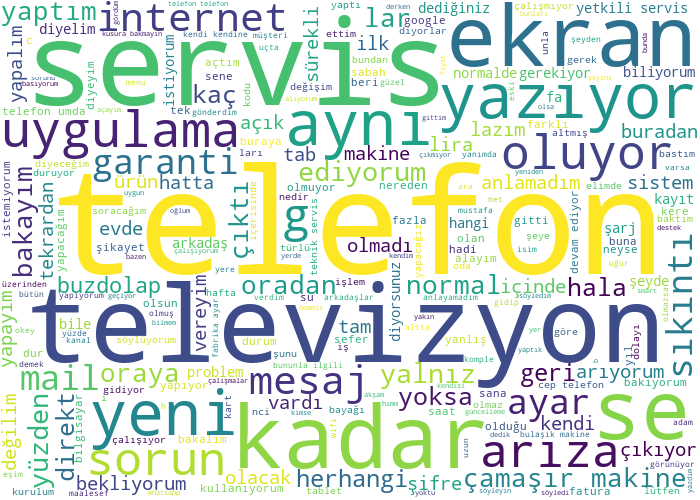

In [ ]:
# kelime bulutu en çok 250 kelime
long_string = ','.join(list(df['CustomerText'].values))
wordcloud = WordCloud(background_color="white", max_words=250, width=700, height=500, contour_width=10, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()


#model

In [ ]:
# BERT, embedding model'e ihtiyaç duyar. embedding model olarak bert base turkish kullanıldı
# Önceden eğitilmiş modeli BERT'te kullanmak için otomatik sınıflar kullanılarak ilk önce tokenize sonra model oluşturulur.
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-cased")
model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-128k-cased")

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/386 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/706M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Model tanımlanır ve çalıştırılır.

topic_model = BERTopic(embedding_model=model, diversity=0.7,
                       language='multilingual', nr_topics=5, n_gram_range=(1,2), verbose=True,
                       calculate_probabilities=True, seed_topic_list=[['telefon','cep telefon','akıllı telefon','android'],['bulaşık', 'çamaşır','klima','ankastre','davlumbaz','süpürge','buzdolap','mikro dalga','fırın'],['televizyon','tv','inç'],['çözüm','çözül','yardım','çözmek'],
                                                                                    ['uzaktan','erişim']])
topics, probs = topic_model.fit_transform(df.CustomerText)

Batches:   0%|          | 0/530 [00:00<?, ?it/s]

2022-07-08 13:11:42,110 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 13:12:12,976 - BERTopic - Reduced dimensionality
2022-07-08 13:12:34,471 - BERTopic - Clustered reduced embeddings
2022-07-08 13:13:13,657 - BERTopic - Reduced number of topics from 143 to 6


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,13585,-1_telefon_servis_garanti_ekran
1,0,949,0_çamaşır makine_garanti_ses_buzdolap
2,1,661,1_servis_vardı_inç_bilgi
3,2,606,2_değilim_müsaitim_ses_istemiyorum
4,3,586,3_telefon_şarj_ses_sıkıntı
5,4,571,4_uydu_telefon_görüntü_sıkıntı


In [ ]:
# BERTopic'te kullanılan kümeleme yöntemi tüm verileri her bir kümeye atamayabilir. Bu veriler "-1" ile belirtilir. Yukarıdaki kod çıktısında görüldüğü üzere "-1"
# verilerimiz toplam verimizin %70'inden fazladır. Bu da istenmeyen bir durumdur. Bunu aykırı verileri bir sütuna atamak için modeli tanımlarken 'calculate_probabilities=True'
# olarak tanımlanır. Daha sonra küme atama olasılık eşiği düşürülerek aykırı(-1) veriler mevcut konulara atanır. Sonuçta aykırı veriler %10 civarına düşürülür.
import numpy as np
probability_threshold = 0.01
new_topics = []
for topic, prob in zip(topics, probs):
    if topic == -1:
        if max(prob) >= probability_threshold:
            new_topics.append(np.argmax(prob))
        else:
            new_topics.append(topic)
    else:
        new_topics.append(topic)


print("-1:", new_topics.count(-1))
print("0:", new_topics.count(0))
print("1:", new_topics.count(1))
print("2:", new_topics.count(2))
print("3:", new_topics.count(3))
print("4:", new_topics.count(4))

-1: 2117
0: 6285
1: 761
2: 751
3: 2043
4: 5001


# model results

In [ ]:
# 5 adet konu ve konuda geçen ilk 10 anahtar kelimesi
for i in range(5):
    print([i+1],'. konu: ',topic_model.get_topic(i) ,'\n')

[1] . konu:  [('çamaşır makine', 0.028798990448919207), ('garanti', 0.011634390204671715), ('ses', 0.011505350901484034), ('buzdolap', 0.010239889765801348), ('sorun', 0.007386478255946491), ('istiyorum', 0.007038561012442354), ('oluyor', 0.006715296952623834), ('kazan', 0.0065496041189107125), ('kaç', 0.006442514053772425), ('değilim', 0.006369388291930964)] 

[2] . konu:  [('servis', 0.02229321239086317), ('vardı', 0.012187950565095517), ('inç', 0.011998348593938292), ('bilgi', 0.009911966950166528), ('garanti', 0.008559786880336024), ('urfa', 0.0080655279278961), ('televizyon kurulumu', 0.007462359491528815), ('evde', 0.007100797063627608), ('montaj', 0.006658901573878951), ('fiyat', 0.00645665844226647)] 

[3] . konu:  [('değilim', 0.10257008597063494), ('müsaitim', 0.05847974049877076), ('ses', 0.02550039785672984), ('istemiyorum', 0.021831682582200945), ('saat', 0.020923218172833425), ('kesik', 0.013899627101246466), ('çalışıyorum', 0.01239181713756371), ('hadi', 0.01115258242251

1. beyaz eşya
2. televizyon
3. çözüm ekibi
4. telefon
5. uzaktan erişim


In [ ]:
topic_model.visualize_topics()

In [ ]:
# çıkan konular ve konulara ait ilk 5 kelimenin olasılıklarının çubuk grafiklerler gösterimi
topic_model.visualize_barchart(top_n_topics=99)

#model evaluation

## C_v (for 5 topics)

In [ ]:
documents = pd.DataFrame({"Document": df.CustomerText,
                          "ID": range(len(df.CustomerText)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]


# tutarlılığı ölçmek (0 ile 1 arası skor / skorun 1'e yakın olması daha iyidir.)
# C_v: Normalleştirilmiş noktasal karşılıklı bilgi (NPMI) ve kosinüs benzerliğini kullanan dolaylı bir doğrulama ölçüsüne dayanır.
# Kayan pencere algoritmasına dayanır. En iyi kelimelerin tek kümeli segmentasyonu, her en iyi kelime vektörü ile tüm en iyi kelime vektörlerinin toplamı arasındaki benzerliğin hesaplanmasını sağlar.
# Benzerlik ölçüsü olarak kosinüs kullanılır. Tutarlılık, bu benzerliklerin aritmetik ortalamasıdır.

cv_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
cv_bert = cv_model.get_coherence()
print('\nTutarlılık skoru: ', cv_bert)


Tutarlılık skoru:  0.6665233096831937


## NPMI (for 5 topics)

In [ ]:
# NPMI metriği, UCI'ın PMI yerine NPMI kullanılarak geliştirilmiş bir tutarlılık ölçüsüdür.
# 1 ile 1 arasında sürekli bir değerdir. 1'e yaklaştıkça birlikte oluşumu gösterir.
# 0'a yakınsa bağımsızlığı gösterir.
npmi_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_npmi')
npmi_bert = npmi_model.get_coherence()
print('\nTutarlılık skoru: ', npmi_bert)


Tutarlılık skoru:  0.03212213806815092


## Topic Diversity (for 5 topics)

[topic diversity metrics github](https://github.com/silviatti/topic-model-diversity)

In [ ]:
!cp /content/drive/MyDrive/diversity_metrics.py .
!cp /content/drive/MyDrive/rbo.py .
!cp /content/drive/MyDrive/word_embeddings_rbo.py .

In [ ]:
from diversity_metrics import *

from gensim.test.utils import datapath
from gensim.models import KeyedVectors

In [ ]:
word_list1 =['çamaşır makine','garanti','ses','buzdolap','sorun','istiyorum','oluyor','kazan','kaç','değilim']
word_list2= ['servis','vardı','inç','bilgi','garanti','urfa','televizyon kurulumu','evde','montaj','fiyat']
word_list3 =['değilim','müsaitim','ses','istemiyorum','saat','kesik','çalışıyorum','hadi','sorun','uygun']
word_list4= ['telefon','şarj','ses','sıkıntı','sorun','cep','umda','ilgili','oluyor','kaç']
word_list5 =['uydu','telefon','görüntü','sıkıntı','ilgili','sistem','evde','kodu','sinyal','internet']


topics = [word_list1, word_list2, word_list3, word_list4, word_list5]

In [ ]:
print("puw:",proportion_unique_words(topics, topk=10)) # Benzersiz kelimelerin oranı(puw)
print("jd:", pairwise_jaccard_diversity(topics, topk=10)) # ortalama İkili Jaccard Mesafesi(jd)
print("irbo p=0.5:",irbo(topics, weight=0.5, topk=10)) # Ters Sıra Önyargılı Örtüşme(irbo) ağırlık=0,5
print("irbo p=0.9:",irbo(topics, weight=0.9, topk=10)) # Ters Sıra Önyargılı Örtüşme(irbo) ağırlık=0,9

## Evaluations by number of topics

In [ ]:
# konu sayısı değiştikçe skor da değişmektedir bu sebeple konu sayısının değişmesiyle skorun değişmesini gözlemlenir ve en iyi konu saysına karar verilir.
import time
def compute_coherence_values(dictionary, topics, corpus, texts, limit, start, step):

    start_time = time.perf_counter()
    cv_values = []
    cnpmi_values=[]
    time_vals=[]
    model2_list = []

    for nr_topics in range(start, limit, step):
        model2 = BERTopic(embedding_model=model, diversity=0.7,
                       language='multilingual', nr_topics=nr_topics, n_gram_range=(1,2), verbose=True,
                       calculate_probabilities=True, seed_topic_list=[['telefon','cep telefon','akıllı telefon','android'],['bulaşık', 'çamaşır','klima','ankastre','davlumbaz','süpürge','buzdolap','mikro dalga','fırın'],['televizyon','tv','inç'],['çözüm','çözül','yardım','çözmek'],
                                                                                    ['uzaktan','erişim']])
        model2_list.append(model2)
        topics, probs = model2.fit_transform(df.CustomerText)

        cleaned_docs = model2._preprocess_text(documents_per_topic.Document.values)

        vectorizer = model2.vectorizer_model
        analyzer = vectorizer.build_analyzer()

        words = vectorizer.get_feature_names() 
        tokens = [analyzer(doc) for doc in cleaned_docs]
        dictionary = corpora.Dictionary(tokens)
        corpus = [dictionary.doc2bow(token) for token in tokens]
        topic_words = [[words for words, _ in model2.get_topic(topic)] 
                    for topic in range(len(set(topics))-1)]
        
        cv_model2 = CoherenceModel(topics=topic_words, texts=tokens, corpus=corpus, dictionary=dictionary, coherence='c_v')
        cnpmi_model2 =CoherenceModel(topics=topic_words, texts=tokens, corpus=corpus, dictionary=dictionary, coherence='c_npmi')


        end_time = time.perf_counter()

        cv_values.append(cv_model2.get_coherence())
        cnpmi_values.append(cnpmi_model2.get_coherence())
        time_vals.append((end_time-start_time)/60)

    return model2_list, cv_values, cnpmi_values, time_vals

### Evaluation of the number of topics in the data set used for 5 topics

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

x = range(3, 20, 3)
model2_list, cv_values, cnpmi_values, time_vals= compute_coherence_values(dictionary=dictionary, topics= topic_words, corpus=corpus, texts=tokens,
                                                                         start=3, limit=20, step=3)

Batches:   0%|          | 0/530 [00:00<?, ?it/s]

2022-07-08 13:42:12,887 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 13:43:04,441 - BERTopic - Reduced dimensionality
2022-07-08 13:43:49,584 - BERTopic - Clustered reduced embeddings
2022-07-08 13:44:39,868 - BERTopic - Reduced number of topics from 146 to 4


Batches:   0%|          | 0/530 [00:00<?, ?it/s]

2022-07-08 13:46:33,256 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 13:47:02,882 - BERTopic - Reduced dimensionality
2022-07-08 13:47:23,182 - BERTopic - Clustered reduced embeddings
2022-07-08 13:48:04,214 - BERTopic - Reduced number of topics from 147 to 7


Batches:   0%|          | 0/530 [00:00<?, ?it/s]

2022-07-08 13:50:04,281 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 13:50:34,095 - BERTopic - Reduced dimensionality
2022-07-08 13:50:56,078 - BERTopic - Clustered reduced embeddings
2022-07-08 13:51:39,781 - BERTopic - Reduced number of topics from 146 to 10


Batches:   0%|          | 0/530 [00:00<?, ?it/s]

2022-07-08 13:53:47,484 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 13:54:17,019 - BERTopic - Reduced dimensionality
2022-07-08 13:54:40,301 - BERTopic - Clustered reduced embeddings
2022-07-08 13:55:22,065 - BERTopic - Reduced number of topics from 143 to 13


Batches:   0%|          | 0/530 [00:00<?, ?it/s]

2022-07-08 13:57:26,862 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 13:57:56,215 - BERTopic - Reduced dimensionality
2022-07-08 13:58:16,894 - BERTopic - Clustered reduced embeddings
2022-07-08 13:59:00,226 - BERTopic - Reduced number of topics from 141 to 16


Batches:   0%|          | 0/530 [00:00<?, ?it/s]

2022-07-08 14:01:12,657 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 14:01:43,687 - BERTopic - Reduced dimensionality
2022-07-08 14:02:08,054 - BERTopic - Clustered reduced embeddings
2022-07-08 14:02:50,451 - BERTopic - Reduced number of topics from 148 to 19


In [ ]:
timeee=[]
timeee.append(time_vals[0])
for i in range(0,5):
    sure=time_vals[i+1]-time_vals[i]
    timeee.append(sure)

sonuc_df = pd.DataFrame(data = {'Konu sayısı': x, 'c_v skoru(0,1)': cv_values, 'NPMI skoru(-1,1)': cnpmi_values, 'Süre(dakika)': timeee})
sonuc_df

,Konu sayısı,"c_v skoru(0,1)","NPMI skoru(-1,1)",Süre(dakika)
0,3,0.660753,-0.002322,3.737155
1,6,0.657956,-0.014132,3.401380
2,9,0.628348,-0.028818,3.604786
3,12,0.639886,-0.011024,3.696375
4,15,0.653453,-0.006664,3.654062
5,18,0.612290,-0.045768,3.819760


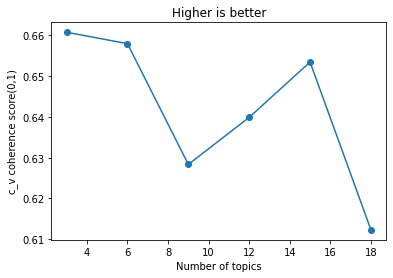

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

start=3; limit=20; step=3;
x = range(start, limit, step)
plt.plot(x, cv_values, 'o-')
plt.xlabel("Number of topics")
plt.ylabel("c_v coherence score(0,1)")
plt.title('Higher is better')
plt.show()


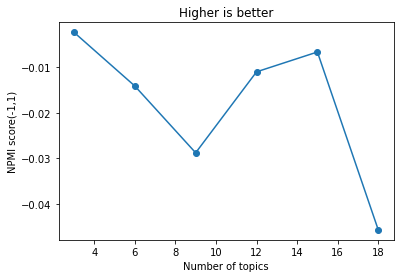

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

start=3; limit=20; step=3;
x = range(start, limit, step)
plt.plot(x, cnpmi_values, 'o-')
plt.xlabel("Number of topics")
plt.ylabel("NPMI score(-1,1)")
plt.title('Higher is better')
plt.show()


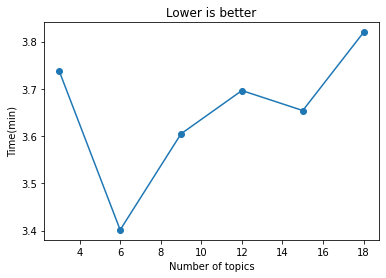

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

start=3; limit=20; step=3;
x = range(start, limit, step)
plt.plot(x, timeee, 'o-')
plt.xlabel("Number of topics")
plt.ylabel("Time(min)")
plt.title('Lower is better')
plt.show()

# Classifying BERTopic's 5 topics without assigning them to any meaningful product/topic

In [ ]:
# yeni veriseti oluşturup sınıflandırma yapılır. Bunun için konu modellemenin çıkarttığı konular(topics) seriye dönüştürülür.
topics_seri = pd.Series(new_topics)
topics_seri

0       -1
1        0
2        3
3        0
4        4
        ..
16953    4
16954    3
16955   -1
16956    1
16957    0
Length: 16958, dtype: int64

In [ ]:
df.CustomerText

0           kampanyaya ılırım başarıyla  uçlandırmak te...
1                 h l gece uğraştım hallettim ilginize ...
2              kaldım     saat derecede evde       sırf...
3            cuma günü   üstte gürbüz lira abimiz arıza...
4                   müsaitim   smarta     pencerede gör...
                               ...                        
16953                     dinliyorum     vardı yüzden  ...
16954           çalışmalar diliyorum zamandı   time işl...
16955        dilerim elimde tablet  galaxy tab mart mar...
16956      opera vardı televizyon silindi   çalışıyordu...
16957         sorunum olacaktı   teknosadan  marka çama...
Name: CustomerText, Length: 16958, dtype: object

In [ ]:
# veriseti oluşturulur. (herhangi bir kümeye ait olmadığı için -1'ler çıkarılır)
df_konular = pd.DataFrame({'konu': topics_seri, 'yazi': df.CustomerText})
df_konular = df_konular.drop(df_konular[(df_konular.konu == -1)].index)
df_konular.to_csv('/content/bert5topics.csv', sep=',')
df_konular

,konu,yazi
1,0,h l gece uğraştım hallettim ilginize ...
2,3,kaldım saat derecede evde sırf...
3,0,cuma günü üstte gürbüz lira abimiz arıza...
4,4,müsaitim smarta pencerede gör...
5,0,faruk klima gece ilk çalıştırdım yapıla...
...,...,...
16952,0,kendisi eşim hattı kullanıyorum derya ...
16953,4,dinliyorum vardı yüzden ...
16954,3,çalışmalar diliyorum zamandı time işl...
16956,1,opera vardı televizyon silindi çalışıyordu...


In [ ]:
df_konular.konu.value_counts()

0    6285
4    5001
3    2043
1     761
2     751
Name: konu, dtype: int64

In [ ]:
# lstm için önişlem
from keras.preprocessing.text import Tokenizer # Makinenin yazıyı anlayabilmesi için Tokenizer ile veri setinde kullanılan en çok 50000 kelime ile bir sözlük oluşturulur.
import numpy as np # numpy dizi işlemleri ve matematik için.

tokenizer = Tokenizer(num_words=50000) # sözlük oluşturulur.
tokenizer.fit_on_texts(df_konular.yazi) # yazılar tokene dönüştürülür.

# toplam token sayısı
num_tokens = [len(tokens) for tokens in df_konular['yazi']]
num_tokens = np.array(num_tokens)

# max token sayısı
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

# Sinir ağımız bizden girdileri eşit boyutta istiyor. Gerçek hayattaki problemlerde bu çok zordur. Bu yüzden verileri aynı boyuta getirmek için pad_sequences kullanılır.
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df_konular['yazi']) # cümleleri sözlükteki kelimelerin karşılığına çevrilir.
Y = pd.get_dummies(df_konular['konu']).values # çıktı verilerimiz anlayacağı hale getirdik.
X_pad = pad_sequences(X, maxlen=max_tokens) # pad_sequences ile aynı boyuta getirilir. uzunluk olarak da önceden hesapladığımız cümle boyutu max_tokens koydum.

# verimiz dengesiz olduğu için RandomOverSampler ile verimizi yeniden örnekliyoruz.
from imblearn.over_sampling import RandomOverSampler 

rus = RandomOverSampler(random_state = 0, sampling_strategy = "minority") # RandomUnderSampler parametreleri belirlenerek değişkene atanır. sampling_strategy, örnekleme stratejisi, minority olarak belirlendi. Çünkü verilerimiz dengesiz olduğu için azınlıkları(minority) yeniden örnekleyerek veriyi dengelemeye çalışıyoruz.
x_rus, y_rus = rus.fit_resample(X_pad, Y) # veriler yeniden örneklendirilir.
print(x_rus.shape, y_rus.shape)

from sklearn.model_selection import train_test_split # verileri eğitim ve test diye bölünür.
x_train, x_test, y_train, y_test = train_test_split(X_pad, Y, test_size = 0.25, random_state = 42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(20375, 2719) (20375, 5)
(11130, 2719) (11130, 5)
(3711, 2719) (3711, 5)


In [ ]:
# lstm
from tensorflow import keras # yapay sinir ağı kullanmak için keras yüklenir.
from math import exp
import matplotlib.pyplot as plt

model_ker = keras.Sequential() # Bir sıralı(Sequential) model, tek girdi ve tek çıktı katmanın olduğu derin öğrenme modeli oluşturmaya yarar.
model_ker.add(keras.layers.Embedding(50000, 100, input_length=max_tokens)) # yazıyı vektörlere çevirir. Tanımı: Pozitif tamsayı (indeksleri) sabit boyutta yoğun vektörlere dönüştürür.
model_ker.add(keras.layers.LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model_ker.add(keras.layers.Dense(5, activation='softmax')) # çıktı katmanı. SoftMAX aktivasyon fonksiyonu, göreceli olasılıkları hesaplar. çoklu sınıf olduğu için softmax kullanılır. ağın son katmanı için aktivasyon olarak kullanılır, çünkü sonuç bir olasılık dağılımı olarak yorumlanabilir. softmanx kullanılmasının sebebi modelin multi-class ve bir doğru cevabın olmasındandır.

model_ker.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # çok sınıflı sınıflandırma problemi olduğu için categorical_crossentropy kullanıldı.

epochs = 50 # Algoritmasının tüm eğitim veri kümesinde kaç kere çalışacağını belirtir.
batch_size = 64 # batch, bir veya daha fazla örnek üzerinde yineleme yapan ve tahminlerde bulunan için bir döngü sayısıdır. her örnekten sonra tahminler beklenen çıktılarla karşılaştırılır ve bir hata hesaplanır. hataya göre tahmini iyileştirmeye çalışır. 

callback = (keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001))# model çalıştırılır(validation loss'u gözle eğer 3 epochdur(devirdir) en az 0.0001 gelişmiyorsa eğitimi durdur.)

history = model_ker.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=[x_test,y_test],callbacks=[callback]) # model çalıştırılır

# modelimizin test verileri doğruluğu
accr = model_ker.evaluate(x_test, y_test)

Epoch 1/50
174/174 [==============================] - 2167s 12s/step - loss: 1.1249 - accuracy: 0.4885 - val_loss: 0.8875 - val_accuracy: 0.6591
Epoch 2/50
174/174 [==============================] - 2168s 12s/step - loss: 0.8898 - accuracy: 0.6800 - val_loss: 0.7940 - val_accuracy: 0.7119
Epoch 3/50
174/174 [==============================] - 2126s 12s/step - loss: 0.6687 - accuracy: 0.7579 - val_loss: 0.7839 - val_accuracy: 0.7230
Epoch 4/50
174/174 [==============================] - 2116s 12s/step - loss: 0.5560 - accuracy: 0.8041 - val_loss: 0.7741 - val_accuracy: 0.7513
Epoch 5/50
174/174 [==============================] - 2124s 12s/step - loss: 0.4614 - accuracy: 0.8358 - val_loss: 0.7758 - val_accuracy: 0.7300
Epoch 6/50
174/174 [==============================] - 2100s 12s/step - loss: 0.3374 - accuracy: 0.8861 - val_loss: 0.7910 - val_accuracy: 0.7103
Epoch 7/50
174/174 [==============================] - 2110s 12s/step - loss: 0.4223 - accuracy: 0.8458 - val_loss: 0.9689 - val_ac

In [ ]:
# tavlamalı lstm
from tensorflow import keras # yapay sinir ağı kullanmak için keras yüklenir.
from math import exp # matematikteki e için
import numpy.random as random # rastgele sayılar için

networktipi = 4  # 4 LSTM

def buildLSTMModel(input_dim3):
    model1 = keras.Sequential() # Bir sıralı(Sequential) model, tek girdi ve tek çıktı katmanın olduğu derin öğrenme modeli oluşturmaya yarar.
    model1.add(keras.layers.Embedding(50000, 100, input_length=max_tokens)) # yazıyı vektörlere çevirir. Tanımı: Pozitif tamsayı (indeksleri) sabit boyutta yoğun vektörlere dönüştürür.
    model1.add(keras.layers.LSTM(100, dropout=0.5, recurrent_dropout=0.5))
    model1.add(keras.layers.Dense(5, activation='softmax')) # çıktı katmanı. SoftMAX aktivasyon fonksiyonu, göreceli olasılıkları hesaplar. çoklu sınıf olduğu için softmax kullanılır. ağın son katmanı için aktivasyon olarak kullanılır, çünkü sonuç bir olasılık dağılımı olarak yorumlanabilir. softmanx kullanılmasının sebebi modelin multi-class ve bir doğru cevabın olmasındandır.
    return model1


def sonucYaz(sonucarray, path2,indis):
    cols2 = ['Adim', 'KabulEdilen','Best','r^2']
    ydf5 = pd.DataFrame(columns=cols2)
    sayi = len(sonucarray)
    p = 0
    while p < sayi:
        ydf5 = ydf5.append(sonucarray[p], ignore_index=True)
        p += 1
    del ydf5
    return
sonucArray=[]
sonucArray2=[]   
model=keras.Sequential()

sonucArray = []
sonucArray2 = []
adimSayisi=0
iterasyonSayisi=0
stepsize=1
shuffle = True

def Tavlama():
    if networktipi == 4:
        model = buildLSTMModel(5)

    global sonucArray
    global adimSayisi
    Eniyi = 0
    EniyiAgirliklar = []
    iterasyonunEnIyisi = 0
    kabulEdilen = 0
    lr = 600 / 10000
    kabuledilenAgirliklar = model.get_weights()
    adim = 0
    guncellenmedi = 0
    iterasyon = 0
    global iterasyonSayisi
    global sonucArray
    while guncellenmedi < 4 :
        if networktipi == 4:
            model = buildLSTMModel(5)

        Temp = 100
        adim=0
        while Temp >= 1:
            if networktipi == 4:
                model = buildLSTMModel(5)
            
            if adim + iterasyon > 0:
                model.set_weights(kabuledilenAgirliklar)
            lr = Temp / 10000
            Opt = keras.optimizers.Adam(learning_rate=lr)
            model.compile(loss='categorical_crossentropy', optimizer=Opt, metrics=['accuracy'])
            if adim + iterasyon == 0:
                model.summary()
            history1=model.fit(x=x_train, y=y_train, epochs=stepsize, batch_size=196, verbose=0,
                                validation_data=(x_test, y_test), shuffle=shuffle)
            y_tahmin = model.predict(x_test)
            accr = model.evaluate(x_test, y_test)
            a=0
            while a<10:
                print("tahmin :"+str(np.argmax(y_tahmin[a]))+", test :"+str(np.argmax(y_test[a])))
                a+=1
            basarim=accr[1]
            delta =  kabulEdilen-basarim
            e=exp(-delta / (Temp/10000))
            rnd = random.uniform(0,1)
            if delta < 0:
                kabulEdilen = basarim
                kabuledilenAgirliklar=model.get_weights()
                
                if kabulEdilen > Eniyi:
                    EniyiAgirliklar=model.get_weights()
                    guncellenmedi = 0
                    Eniyi=kabulEdilen
            elif rnd > exp(-delta / (Temp/1000)):
                kabulEdilen = basarim
                kabuledilenAgirliklar = model.get_weights()
                
            print("----Adim:"+str(adim)+"/"+str(iterasyon)+" ----")
            print('Temp :' + str(Temp))
            print('lr :' + str(lr))
            print("randomSayi : "+str(rnd)+" exp : "+str(e))
            print('başarım :' + str(basarim))
            print('best :' + str(Eniyi))
            print('kabul edilen :' + str(kabulEdilen))
            adim += 1
            Temp = Temp * 0.99
            if adim==200:
                Temp=1
            sonucArray.append({'Adim':adim,'KabulEdilen':kabulEdilen,'Best':Eniyi,'accr':0})
            del model
        iterasyon += 1
        guncellenmedi += 1
        adimSayisi=iterasyon*adim
        sonucYaz(sonucArray, "./Sonuc",1000+iterasyon*adim)
        print(metrics.classification_report(y_true = np.argmax(y_test,axis=1), y_pred=np.argmax(y_tahmin,axis=1), zero_division=0))
    iterasyonSayisi=iterasyon
    del history1



from datetime import datetime
start = datetime.now()

Tavlama()

end = datetime.now()
print(end-start)
print("****Bitti****")

In [ ]:
from sklearn.feature_extraction.text import  TfidfVectorizer # Metinleri makinenin anlayacağı dile çevirmek için vektörlere çevirmeliyiz. Bu yüzden bir ham doküman koleksiyonunu TF-IDF özelliklerinin bir matrisine dönüştürmek için TfidfVectorizer kullanılır.
# TF: Term Frequency=terim frekansı: bir dokümanda belirli bir terimden kaç tane olduğunu bulur. / IDF: Inverse Document Frequency=Ters doküman frekansı: belirli terimin kaç farklı dokümanda geçtiğini hesaplar. 
# Tf-idf ise belirli terimin kaç farklı dokümanda kaç kere geçtiğine önem verir. Bu yüzden tf-idf kullanıldı.
from sklearn.model_selection import train_test_split # Veriyi eğitim ve test diye ayırmak için modül
from sklearn import metrics # performans değerlendirmesi için metrik modülü yüklenir
from sklearn.metrics import accuracy_score # doğruluk skoru hesaplamak için yüklenir.

In [ ]:
# lstm dışındaki diğer sınıflandırma algoritmaları için önişlem

dataDoc = df_konular['yazi'].values.tolist() # Metin verileri girdi olarak seçilir.
dataClass = df_konular['konu'].values.tolist() # kategori verileri çıktı olarak seçilir.

# Tfidf skorlama yöntemini kullanarak veriyi sayısallaştırmadan önce eğitim ve test olarak veriyi ayırıyoruz.
x_train, x_test, y_train, y_test = train_test_split(dataDoc, dataClass, test_size = 0.25, random_state = 42)

#tfidf işlemi
tfidf_vectorizer = TfidfVectorizer(min_df=3) # min_df: Nadiren görünen terimleri göz ardı etmek için kullanılır. Şu anda bir terim 3 dokümandan az geçiyorsa göz ardı edilecek.

# metin verileri makinenin anlayacağı dile vektörlere dönüştürülür.
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)


In [ ]:
from sklearn.linear_model import SGDClassifier # Lojistik regresyon kullanmak için yüklenir.
lrsgd = SGDClassifier(loss="log", max_iter=1000, alpha=0.0001, random_state=42) # saga çözümleyicisi sag'ın gelişmiş bir varyantıdır. Temelinde stokastik ortalama gradyan inişi baz alır. 
lrsgd_clf = lrsgd.fit(x_train_tfidf, y_train) # model eğitilir.
pred_test_lrsgd = lrsgd_clf.predict(x_test_tfidf) # tahmin yapılır

# Modelimizde overfitting olmuş mu diye bakmak için eğitim skoru ve test skoru karşılaştırılır. eğer değerler yakınsa overfitting yoktur denir.
# Eğitim skoru
pred_train_lrsgd = lrsgd_clf.predict(x_train_tfidf) # x eğitim verileri de karşılaştırma yapmak için tahmin edilir.
print('SGD''li Lojistik Regresyon Model eğitim veri seti doğruluğu: {0:0.4f}'. format(metrics.accuracy_score(y_train, pred_train_lrsgd)))

# Test skoru
print('SGD''li Lojistik Regresyon Model test veri seti doğruluğu: {0:0.4f}'.format(metrics.accuracy_score(y_test, pred_test_lrsgd)))

SGDli Lojistik Regresyon Model eğitim veri seti doğruluğu: 0.8071
SGDli Lojistik Regresyon Model test veri seti doğruluğu: 0.7074


In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred=pred_test_lrsgd, zero_division=0)) # y_true: doğru hedef değişkenleridir. y_pred: sınıflandırma modelinden çıkan tahmin sonuçlarıdır.

              precision    recall  f1-score   support

           0       0.72      0.91      0.81      1566
           1       0.89      0.17      0.28       185
           2       0.83      0.31      0.45       198
           3       0.74      0.41      0.53       539
           4       0.67      0.72      0.69      1223

    accuracy                           0.71      3711
   macro avg       0.77      0.50      0.55      3711
weighted avg       0.72      0.71      0.68      3711



In [ ]:
from datetime import datetime
start = datetime.now()

from sklearn.linear_model import LogisticRegression # Lojistik regresyon kullanmak için yüklenir.
lr = LogisticRegression(solver='saga', random_state=42,multi_class='multinomial', max_iter=1000) # saga çözümleyicisi sag'ın gelişmiş bir varyantıdır. Temelinde stokastik ortalama gradyan inişi baz alır. 
lr_clf = lr.fit(x_train_tfidf, y_train) # model eğitilir.
pred_test_lr = lr_clf.predict(x_test_tfidf) # tahmin yapılır

end = datetime.now()
print(end-start)
print("****Bitti****")

# Modelimizde overfitting olmuş mu diye bakmak için eğitim skoru ve test skoru karşılaştırılır. eğer değerler yakınsa overfitting yoktur denir.
# Eğitim skoru
pred_train_lr = lr_clf.predict(x_train_tfidf) # x eğitim verileri de karşılaştırma yapmak için tahmin edilir.
print('Lojistik Regresyon Model eğitim veri seti doğruluğu: {0:0.4f}'. format(metrics.accuracy_score(y_train, pred_train_lr)))

# Test skoru
print('Lojistik Regresyon Model test veri seti doğruluğu: {0:0.4f}'.format(metrics.accuracy_score(y_test, pred_test_lr)))
print('Lojistik Regresyon Model test veri seti f1: {0:0.4f}'.format(metrics.f1_score(y_test, pred_test_lr, average='weighted')))

0:00:00.878833
****Bitti****
Lojistik Regresyon Model eğitim veri seti doğruluğu: 0.8580
Lojistik Regresyon Model test veri seti doğruluğu: 0.7278
Lojistik Regresyon Model test veri seti f1: 0.7113


In [ ]:
from sklearn import metrics # performans değerlendirmesi için metrik modülü yüklenir.
print(metrics.classification_report(y_true = y_test, y_pred=pred_test_lr, zero_division=0)) # y_true: doğru hedef değişkenleridir. y_pred: sınıflandırma modelinden çıkan tahmin sonuçlarıdır.

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1566
           1       0.88      0.31      0.46       185
           2       0.82      0.34      0.48       198
           3       0.73      0.46      0.57       539
           4       0.69      0.74      0.71      1223

    accuracy                           0.73      3711
   macro avg       0.77      0.55      0.61      3711
weighted avg       0.73      0.73      0.71      3711



In [ ]:
from datetime import datetime
start = datetime.now()

import lightgbm as lgbm # lightgbm kullanmak için yüklenir.

# lightgbm modeli tanımlanır.
clf_LGBM = lgbm.LGBMClassifier(min_data_in_leaf=10,feature_fraction=0.5, learning_rate=0.01, random_state=42, max_depth=3, num_leaves=7, objective='multiclass')
# learning_rate=0.01> öğrenme adım sayısını doğruluğu artırmak adına düşürdüm. 
# overfitting düşürmek için min_data_in_leaf kullandım. Böylece her yaprakta bulunacak minimum veriyi çoğaltarak bir yaprağın çok spesifik hale gelmesini engelledim.
# overfitting düşürmek için feature_fraction kullandım. Böylece her iterasyonda rastgele seçilecek özniteliklerin oranı belirlendi.

clf_LGBM.fit(x_train_tfidf, y_train) # model eğitilir.

pred_test_LGBM = clf_LGBM.predict(x_test_tfidf) # Tahmin yapılır.

end = datetime.now()
print(end-start)
print("****Bitti****")


0:00:14.794692
****Bitti****


In [ ]:
from sklearn import metrics # performans değerlendirmesi için metrik modülü yüklenir.

print(metrics.classification_report(y_true = y_test, y_pred=pred_test_LGBM, zero_division=0)) # y_true: doğru hedef değişkenleridir. y_pred: sınıflandırma modelinden çıkan tahmin sonuçlarıdır.

              precision    recall  f1-score   support

           0       0.70      0.91      0.79      1566
           1       0.00      0.00      0.00       185
           2       1.00      0.01      0.01       198
           3       1.00      0.01      0.01       539
           4       0.57      0.78      0.66      1223

    accuracy                           0.64      3711
   macro avg       0.65      0.34      0.30      3711
weighted avg       0.68      0.64      0.55      3711



In [ ]:
# Modelimizde overfitting olmuş mu diye bakmak için eğitim skoru ve test skoru karşılaştırılır. eğer değerler yakınsa overfitting yoktur denir.
# Eğitim skoru
pred_train_LGBM = clf_LGBM.predict(x_train_tfidf) # x eğitim verileri de karşılaştırma yapmak için tahmin edilir.


print('LightGBM Model eğitim veri seti doğruluğu: {0:0.4f}'. format(metrics.accuracy_score(y_train, pred_train_LGBM)))

# Test skoru
print('LightGBM Model test veri seti doğruluğu: {0:0.4f}'.format(metrics.accuracy_score(y_test, pred_test_LGBM)))
print('lightgbm Model test veri seti f1: {0:0.4f}'.format(metrics.f1_score(y_test, pred_test_LGBM, average='weighted')))

LightGBM Model eğitim veri seti doğruluğu: 0.6569
LightGBM Model test veri seti doğruluğu: 0.6430
lightgbm Model test veri seti f1: 0.5543


In [ ]:
from sklearn import svm

clf_sgd = SGDClassifier(loss="hinge", alpha=0.001, random_state=42) # sgd optimizasyonu ile lineer kernel SVC
# alpha, iki amaca hizmet eder. Hem C gibi bir düzenleme parametresi hem de varsayılan zamanlama kapsamındaki ilk öğrenme oranıdır(learning_rate).
# hinge loss, sınıflandırma sınırından kayıp hesaplamasında mesafeyi içeren belirli bir kayıp fonksiyonudur. SVM'de kullanılır.
clf_sgd.fit(x_train_tfidf, y_train) # model eğitilir.
pred_test_svcsgd = clf_sgd.predict(x_test_tfidf) # tahmin ettirilir.

# Modelimizde overfitting olmuş mu diye bakmak için eğitim skoru ve test skoru karşılaştırılır. eğer değerler yakınsa overfitting yoktur denir.
# Eğitim skoru
pred_train_svcsgd = clf_sgd.predict(x_train_tfidf) # x eğitim verileri de karşılaştırma yapmak için tahmin edilir.
print('svcsgd eğitim veri seti doğruluğu: {0:0.4f}'. format(metrics.accuracy_score(y_train, pred_train_svcsgd)))

# Test skoru
print('svcsgd Model test veri seti doğruluğu: {0:0.4f}'.format(metrics.accuracy_score(y_test, pred_test_svcsgd)))

svcsgd eğitim veri seti doğruluğu: 0.6898
svcsgd Model test veri seti doğruluğu: 0.6521


In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred=pred_test_svcsgd, zero_division=0)) # y_true: doğru hedef değişkenleridir. y_pred: sınıflandırma modelinden çıkan tahmin sonuçlarıdır.

              precision    recall  f1-score   support

           0       0.65      0.92      0.77      1566
           1       0.00      0.00      0.00       185
           2       0.89      0.20      0.33       198
           3       0.89      0.13      0.23       539
           4       0.63      0.71      0.66      1223

    accuracy                           0.65      3711
   macro avg       0.61      0.39      0.40      3711
weighted avg       0.66      0.65      0.59      3711



In [ ]:
clf_lin = svm.SVC(kernel='linear', C=0.9, decision_function_shape='ovo', random_state=42) # lineer kernel SVC
# C, SVC için bir parametredir ve verinin yanlış sınıflandırılması için cezadır. C düştükçe sınıflandırıcı yanlış sınıflandırılmış veri noktalarını göz ardı eder.
clf_lin.fit(x_train_tfidf, y_train) # model eğitilir.
pred_test_svclin = clf_lin.predict(x_test_tfidf) # tahmin ettirilir.

# Modelimizde overfitting olmuş mu diye bakmak için eğitim skoru ve test skoru karşılaştırılır. eğer değerler yakınsa overfitting yoktur denir.
# Eğitim skoru
pred_train_svclin = clf_lin.predict(x_train_tfidf) # x eğitim verileri de karşılaştırma yapmak için tahmin edilir.
print('svclin eğitim veri seti doğruluğu: {0:0.4f}'. format(metrics.accuracy_score(y_train, pred_train_svclin)))

# Test skoru
print('svclin Model test veri seti doğruluğu: {0:0.4f}'.format(metrics.accuracy_score(y_test, pred_test_svclin)))

svclin eğitim veri seti doğruluğu: 0.9073
svclin Model test veri seti doğruluğu: 0.7435


In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred=pred_test_svclin, zero_division=0)) # y_true: doğru hedef değişkenleridir. y_pred: sınıflandırma modelinden çıkan tahmin sonuçlarıdır.

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1566
           1       0.87      0.48      0.62       185
           2       0.81      0.42      0.55       198
           3       0.73      0.49      0.59       539
           4       0.69      0.75      0.72      1223

    accuracy                           0.74      3711
   macro avg       0.78      0.61      0.66      3711
weighted avg       0.75      0.74      0.73      3711



In [ ]:
from datetime import datetime
start = datetime.now()

from sklearn.svm import LinearSVC # Libsvm kütüphanesi yerine Liblinear kütüphanesini kullanır. Daha esnektir.
lrsvc = LinearSVC(C=0.2, random_state=42) # C, SVC için bir parametredir ve verinin yanlış sınıflandırılması için cezadır. C düştükçe sınıflandırıcı yanlış sınıflandırılmış veri noktalarını göz ardı eder.
lrsvc_clf = lrsvc.fit(x_train_tfidf, y_train) # model eğitilir.
pred_test_lrsvc = lrsvc_clf.predict(x_test_tfidf) # tahmin yapılır

end = datetime.now()
print(end-start)
print("****Bitti****")
# Modelimizde overfitting olmuş mu diye bakmak için eğitim skoru ve test skoru karşılaştırılır. eğer değerler yakınsa overfitting yoktur denir.
# Eğitim skoru
pred_train_lrsvc = lrsvc_clf.predict(x_train_tfidf) # x eğitim verileri de karşılaştırma yapmak için tahmin edilir.
print('lineer svc Model eğitim veri seti doğruluğu: {0:0.4f}'. format(metrics.accuracy_score(y_train, pred_train_lrsvc)))

# Test skoru
print('lineer svc Model test veri seti doğruluğu: {0:0.4f}'.format(metrics.accuracy_score(y_test, pred_test_lrsvc)))
print('lineer svc Model test veri seti f1: {0:0.4f}'.format(metrics.f1_score(y_test, pred_test_lrsvc, average='weighted')))

0:00:00.218649
****Bitti****
lineer svc Model eğitim veri seti doğruluğu: 0.8871
lineer svc Model test veri seti doğruluğu: 0.7249
lineer svc Model test veri seti f1: 0.7087


In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred=pred_test_lrsvc, zero_division=0)) # y_true: doğru hedef değişkenleridir. y_pred: sınıflandırma modelinden çıkan tahmin sonuçlarıdır.

              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1566
           1       0.90      0.30      0.45       185
           2       0.80      0.35      0.49       198
           3       0.71      0.47      0.57       539
           4       0.69      0.73      0.71      1223

    accuracy                           0.72      3711
   macro avg       0.77      0.55      0.61      3711
weighted avg       0.73      0.72      0.71      3711

